In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
data = xr.open_zarr('/storage/shared/oceanparcels/output_data/data_Claudio/tests/YOIHLQ.zarr/')

In [3]:
data

<xarray.Dataset>
Dimensions:           (traj: 1000, obs: 4)
Dimensions without coordinates: traj, obs
Data variables: (12/14)
    Kz                (traj, obs) float32 dask.array<chunksize=(1000, 4), meta=np.ndarray>
    abs_salinity      (traj, obs) float32 dask.array<chunksize=(1000, 4), meta=np.ndarray>
    cons_temperature  (traj, obs) float32 dask.array<chunksize=(1000, 4), meta=np.ndarray>
    density           (traj, obs) float32 dask.array<chunksize=(1000, 4), meta=np.ndarray>
    diameter          (traj, obs) float32 dask.array<chunksize=(1000, 4), meta=np.ndarray>
    lat               (traj, obs) float64 dask.array<chunksize=(1000, 4), meta=np.ndarray>
    ...                ...
    seafloor          (traj, obs) float32 dask.array<chunksize=(1000, 4), meta=np.ndarray>
    time              (traj, obs) datetime64[ns] dask.array<chunksize=(1000, 4), meta=np.ndarray>
    trajectory        (traj, obs) float64 dask.array<chunksize=(1000, 4), meta=np.ndarray>
    v_s               (traj, obs) float32 dask.array<chunksize=(1000, 4), meta=np.ndarray>
    w                 (traj, obs) float32 dask.array<chunksize=(1000, 4), meta=np.ndarray>
    z                 (traj, obs) float64 dask.array<chunksize=(1000, 4), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        v2.3.0-239-g31f81d51

In [4]:
data['w'][:].values

array([[ 5.2301271e-05,  4.8171973e-05,  2.6144638e-05, -2.8412351e-06],
       [ 5.2301271e-05,  4.8171973e-05,  2.6144638e-05, -2.8412351e-06],
       [ 5.2301271e-05,  4.8171973e-05,  2.6144638e-05, -2.8412351e-06],
       ...,
       [ 5.2301271e-05,  4.8171973e-05,  2.6144638e-05, -2.8412351e-06],
       [ 5.2301271e-05,  4.8171973e-05,  2.6144638e-05, -2.8412351e-06],
       [ 5.2301271e-05,  4.8171973e-05,  2.6144638e-05, -2.8412351e-06]],
      dtype=float32)

In [10]:
data['diameter'].values

array([[1.e-04, 1.e-04, 1.e-04, 1.e-04],
       [1.e-04, 1.e-04, 1.e-04, 1.e-04],
       [1.e-04, 1.e-04, 1.e-04, 1.e-04],
       ...,
       [1.e-04, 1.e-04, 1.e-04, 1.e-04],
       [1.e-04, 1.e-04, 1.e-04, 1.e-04],
       [1.e-04, 1.e-04, 1.e-04, 1.e-04]], dtype=float32)

In [29]:
data['seafloor'][:,0].values

array([5138.972, 5138.972, 5138.972, 5138.972, 5138.972, 5138.972,
       5138.972, 5138.972, 5138.972, 5138.972, 5138.972, 5138.972,
       5138.972, 5138.972, 5138.972, 5138.972, 5138.972, 5138.972,
       5138.972, 5138.972, 5138.972, 5138.972, 5138.972, 5138.972,
       5138.972, 5138.972, 5138.972, 5138.972, 5138.972, 5138.972,
       5138.972, 5138.972, 5138.972, 5138.972, 5138.972, 5138.972,
       5138.972, 5138.972, 5138.972, 5138.972, 5138.972, 5138.972,
       5138.972, 5138.972, 5138.972, 5138.972, 5138.972, 5138.972,
       5138.972, 5138.972, 5138.972, 5138.972, 5138.972, 5138.972,
       5138.972, 5138.972, 5138.972, 5138.972, 5138.972, 5138.972,
       5138.972, 5138.972, 5138.972, 5138.972, 5138.972, 5138.972,
       5138.972, 5138.972, 5138.972, 5138.972, 5138.972, 5138.972,
       5138.972, 5138.972, 5138.972, 5138.972, 5138.972, 5138.972,
       5138.972, 5138.972, 5138.972, 5138.972, 5138.972, 5138.972,
       5138.972, 5138.972, 5138.972, 5138.972, 5138.972, 5138.

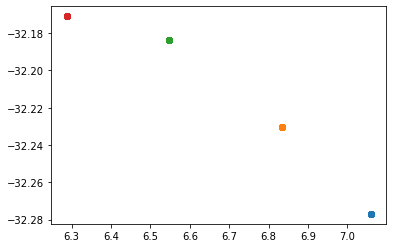

In [27]:
plt.scatter(data['lon'][:, 3].values, data['lat'][:, 3].values)
plt.scatter(data['lon'][:, 2], data['lat'][:, 2])
plt.scatter(data['lon'][:, 1], data['lat'][:, 1])
plt.scatter(data['lon'][:, 0], data['lat'][:, 0])